In [2]:
import xarray as xr
import numpy as np
from math import pi
import datetime as dt
import os
import sys
from pathlib import Path
from os.path import exists
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
#from pathlib import Path
from datetime import *; from dateutil.relativedelta import *
#from scipy.interpolate import make_interp_spline, BSpline
#from scipy.signal import savgol_filter
%matplotlib inline
sys.path.append('./subroutines/')
from read_gridded_data import get_monthly_data


In [5]:
filelist=[]
dir_data = 'F:/data/sst/jpl_mur/v4.1/2003/'
for filename in Path(dir_data).rglob('*90000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc'):
    filelist.append(filename)
ds=xr.open_dataset(filelist[0])#,combine='nested',concat_dim='time').drop({'analysis_error'})
#ds = ds.resample(time='M',keep_attrs=True).mean(skipna=False,keep_attrs=True)


SyntaxError: invalid syntax (<ipython-input-5-a8aaa25c5323>, line 7)

In [11]:
ds.keys()

KeysView(<xarray.Dataset>
Dimensions:           (lat: 17999, lon: 36000, time: 1)
Coordinates:
  * time              (time) datetime64[ns] 2003-01-01T09:00:00
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -179.99 -179.98 -179.97 ... 179.99 180.0
Data variables:
    analysed_sst      (time, lat, lon) float32 nan nan nan ... 271.35 271.35
    analysis_error    (time, lat, lon) float32 nan nan nan ... 0.34 0.34 0.34
    mask              (time, lat, lon) float32 2.0 2.0 2.0 2.0 ... 9.0 9.0 9.0
    sea_ice_fraction  (time, lat, lon) float32 nan nan ... 0.97999996 0.97999996
Attributes:
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:          

In [12]:
ds..maskattrs

{'long_name': 'sea/land field composite mask',
 'valid_min': 1,
 'valid_max': 31,
 'flag_masks': array([ 1,  2,  4,  8, 16], dtype=int8),
 'flag_values': array([ 1,  2,  5,  9, 13], dtype=int8),
 'flag_meanings': '1=open-sea, 2=land, 5=open-lake, 9=open-sea with ice in the grid, 13=open-lake with ice in the grid',
 'comment': 'mask can be used to further filter the data.',
 'source': 'GMT "grdlandmask", ice flag from sea_ice_fraction data'}

In [2]:
ds=get_monthly_data('cmc_sst')
ds

<xarray.Dataset>
Dimensions:           (lat: 901, lon: 1800, time: 339)
Coordinates:
  * time              (time) datetime64[ns] 1991-09-30 1991-10-31 ... 2019-11-30
  * lat               (lat) float32 -90.0 -89.8 -89.6 -89.4 ... 89.6 89.8 90.0
  * lon               (lon) float32 -180.0 -179.8 -179.6 ... 179.6 179.79999
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 901, 1800), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(1, 901, 1800), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 901, 1800), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(1, 901, 1800), meta=np.ndarray>
Attributes:
    Conventions:                CF-1.4
    title:                      CMC 0.2 deg global sea surface temperature an...
    summary:                    Applies the method of statistical interpolati...
    references:                 Brasnett B. 2

In [31]:
ds=ds.where(ds.mask==1)
date_start,date_end,date_end2='1993-01-01','2018-12-31','2019-12-31'
ds=ds.sel(time=slice(date_start,date_end2))
ds_mean = ds.sel(lat=slice(32,45),lon=slice(-128.,-120.))
ds_mean_tem=ds_mean.sel(time=slice(date_start,date_end))
data_climatology = ds_mean_tem.groupby('time.month').mean('time',keep_attrs=True,skipna=False)
data_anomaly = ds_mean.groupby('time.month') - data_climatology
ds_anom=data_anomaly
global_attributes = ds.attrs
data_anomaly.attrs = global_attributes      
ds_mean_clim=ds_mean-ds_anom
ds_mean_clim.load()
data_anomaly.load()
data_climatology.load()

<xarray.Dataset>
Dimensions:           (lat: 66, lon: 41, month: 12)
Coordinates:
  * lat               (lat) float32 32.0 32.2 32.4 32.6 ... 44.4 44.6 44.8 45.0
  * lon               (lon) float32 -128.0 -127.8 -127.6 ... -120.2 -120.0
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    analysed_sst      (month, lat, lon) float32 289.79083 289.75885 ... nan nan
    analysis_error    (month, lat, lon) float32 0.22481391 0.22434242 ... nan
    sea_ice_fraction  (month, lat, lon) float32 0.0 0.0 0.0 0.0 ... nan nan nan
    mask              (month, lat, lon) float32 1.0 1.0 1.0 1.0 ... nan nan nan
Attributes:
    Conventions:                CF-1.4
    title:                      CMC 0.2 deg global sea surface temperature an...
    summary:                    Applies the method of statistical interpolati...
    references:                 Brasnett B. 2008. The impact of satellite ret...
    institution:                CMC
    history:                    Proc

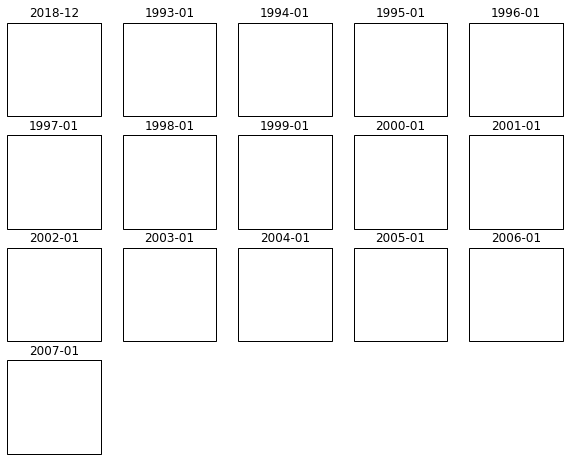

In [60]:
import cartopy.crs as ccrs
fig=plt.figure(figsize=(10,10))
xlon,xlat=np.meshgrid(data_anomaly.lon,data_anomaly.lat)
for i in range(16):
    ax=plt.subplot(5,5,i+1,projection=ccrs.Orthographic())
    ii=(i-1)*12
    ax.pcolormesh(xlon,xlat,data_anomaly.analysed_sst[ii,:,:],transform=ccrs.PlateCarree())
    ax.coastlines(resolution='50m')
    ax.set_title(str(data_anomaly.time[ii].dt.year.data)+'-'+str(data_anomaly.time[ii].dt.month.data).zfill(2))

In [53]:
data_anomaly2=data_anomaly.copy(deep=True)
data_anomaly2['lon']=data_anomaly2.lon+360